Лабораторная работа №2  **"Использование численных
 методов в задачах оптимизации"**

Тема: Реализация и исследование алгоритмов BFGS и L-BFGS для задачи оптимизации

**Цель работы**

Изучить и реализовать квазиньютоновские методы оптимизации — алгоритмы **BFGS** и **L-BFGS** — на примере конкретной функции, а также сравнить их эффективность при различных способах задания градиента и начального приближения матрицы Гессе.

**Теоретические сведения**

Квазиньютоновские методы оптимизации основаны на приближении обратной матрицы Гессе
𝐻
𝑘
	, которая используется для уточнения направления поиска минимума функции.
В отличие от классического метода Ньютона, где требуется вычислять и инвертировать полную матрицу Гессе, BFGS строит её приближение, используя информацию о приращениях градиентов и координат.

Метод L-BFGS является модификацией BFGS, использующей только несколько последних обновлений (память ограничена), что делает его значительно менее требовательным к памяти при сохранении высокой скорости сходимости.

**Исходные данные**

Рассматривается оптимизационная задача поиска минимума функции
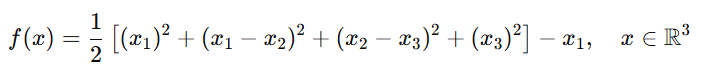

Данная функция выпуклая и дважды дифференцируема, поэтому для неё могут применяться алгоритмы BFGS и L-BFGS.

# Входные данные

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [ ]:
# 1. Функция (8) и градиенты

def f(x):
    # f(x) = 0.5 * [x1^2 + (x1-x2)^2 + (x2-x3)^2 + x3^2] - x1
    return 0.5 * (x[0]**2 + (x[0]-x[1])**2 + (x[1]-x[2])**2 + x[2]**2) - x[0]

def grad_f(x):
    # аналитический градиент
    return np.array([
        2*x[0] - x[1] - 1,
        2*x[1] - x[0] - x[2],
        2*x[2] - x[1]
    ])

Здесь определяется целевая функция (8) и её аналитический градиент.
Функция является выпуклой и дважды дифференцируемой, поэтому для неё могут применяться алгоритмы BFGS и L-BFGS.
Аналитический градиент вычисляется явно по формулам:
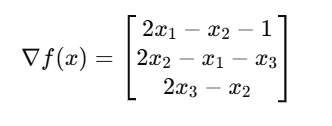

## Численный градиент

In [ ]:
def num_grad(f, x, h=1e-5):
    n = len(x)
    grad = np.zeros(n)
    for i in range(n):
        x_forward = x.copy()
        x_backward = x.copy()
        x_forward[i] += h
        x_backward[i] -= h
        grad[i] = (f(x_forward) - f(x_backward)) / (2*h)
    return grad

Здесь реализована функция для вычисления численного градиента по **центральной разностной схеме**.
Этот подход используется для проверки корректности аналитического выражения градиента и для случаев, когда аналитическую форму получить сложно.

## Поиск длины шага α

In [ ]:
# 2. Линейный поиск с условием Вольфе

def line_search(f, grad, x, p, alpha0=1, c1=1e-4, c2=0.9):
    alpha = alpha0
    fx = f(x)
    gtp = np.dot(grad(x), p)
    while True:
        if f(x + alpha*p) > fx + c1*alpha*gtp:
            alpha *= 0.5
        elif np.dot(grad(x + alpha*p), p) < c2*gtp:
            alpha *= 0.5
        else:
            break
    return alpha

Функция line_search реализует поиск длины шага α, удовлетворяющего условиям Вольфе.
Это гарантирует уменьшение значения целевой функции и обеспечивает устойчивость сходимости метода.

# BFGS

In [ ]:
# 3. BFGS

def BFGS(f, grad, x0, H0=None, tol=1e-6, max_iter=1000):
    n = len(x0)
    x = x0.copy()
    H = np.eye(n) if H0 is None else H0.copy()
    history = []
    t0 = time.time()

    for _ in range(max_iter):
        g = grad(x)
        history.append(f(x))
        if np.linalg.norm(g) < tol:
            break
        p = -H @ g
        alpha = line_search(f, grad, x, p)
        s = alpha * p
        x_new = x + s
        y = grad(x_new) - g
        ys = np.dot(y, s)
        if ys > 1e-10:
            rho = 1.0 / ys
            I = np.eye(n)
            H = (I - rho*np.outer(s, y)) @ H @ (I - rho*np.outer(y, s)) + rho*np.outer(s, s)
        x = x_new
    t_total = time.time() - t0
    return x, f(x), history, t_total

Реализован классический алгоритм **BFGS** (Бройден–Флетчер–Гольдфарб–Шанно).


Алгоритм реализован в двух вариантах:

- с аналитическим и численным вычислением градиента функции (на основе конечных разностей);

- с двумя вариантами инициализации приближённой матрицы Гессе: через единичную матрицу и через численно вычисленную матрицу Гессе;

Также выполняется обновление матрицы по формуле:

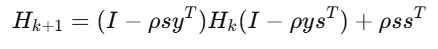

# Численное приближение Гессе

In [ ]:
# 4. Численный Гессе

def numeric_hessian(f, x, h=1e-4):
    n = len(x)
    H = np.zeros((n, n))
    e = np.eye(n)
    fx = f(x)
    for i in range(n):
        H[i, i] = (f(x + h*e[i]) - 2*fx + f(x - h*e[i])) / (h**2)
        for j in range(i+1, n):
            f_pp = f(x + h*e[i] + h*e[j])
            f_pm = f(x + h*e[i] - h*e[j])
            f_mp = f(x - h*e[i] + h*e[j])
            f_mm = f(x - h*e[i] - h*e[j])
            Hij = (f_pp - f_pm - f_mp + f_mm) / (4*h*h)
            H[i, j] = Hij
            H[j, i] = Hij
    return H

В этом блоке реализовано **численное приближение матрицы Гессе** методом конечных разностей.
Такая матрица используется для инициализации BFGS, чтобы ускорить сходимость на первых итерациях.

#  L-BFGS

In [ ]:
# 5. L-BFGS

def LBFGS(f, grad, x0, m=5, tol=1e-6, max_iter=1000):
    x = x0.copy()
    s_list, y_list = [], []
    history = []
    t0 = time.time()

    for _ in range(max_iter):
        g = grad(x)
        history.append(f(x))
        if np.linalg.norm(g) < tol:
            break

        q = g.copy()
        alpha_list, rho_list = [], []

        # обратный проход
        for s, y in reversed(list(zip(s_list, y_list))):
            rho = 1.0 / np.dot(y, s)
            alpha = rho * np.dot(s, q)
            q -= alpha * y
            alpha_list.append(alpha)
            rho_list.append(rho)

        gamma = np.dot(s_list[-1], y_list[-1]) / np.dot(y_list[-1], y_list[-1]) if y_list else 1.0
        r = gamma * q

        # прямой проход
        for s, y, alpha, rho in zip(s_list, y_list, reversed(alpha_list), reversed(rho_list)):
            beta = rho * np.dot(y, r)
            r += s * (alpha - beta)

        p = -r
        alpha = line_search(f, grad, x, p)
        s = alpha * p
        x_new = x + s
        y = grad(x_new) - g

        if np.dot(y, s) > 1e-10:
            s_list.append(s)
            y_list.append(y)
            if len(s_list) > m:
                s_list.pop(0)
                y_list.pop(0)
        x = x_new

    t_total = time.time() - t0
    return x, f(x), history, t_total

Алгоритм **L-BFGS** (Limited-memory BFGS) использует только несколько последних пар
(
𝑠
𝑘
,
𝑦
𝑘
),
что позволяет значительно сократить требования к памяти при сохранении качества сходимости.
Здесь параметр m=5 определяет глубину памяти.

# Сравнение

In [ ]:
# 6. Сравнение вариантов

x0 = np.array([0.0, 0.0, 0.0])

# BFGS аналитический, H0=I
x_bfgs_a, f_bfgs_a, hist_bfgs_a, t1 = BFGS(f, grad_f, x0)

# BFGS численный, H0=I
x_bfgs_n, f_bfgs_n, hist_bfgs_n, t2 = BFGS(f, lambda x: num_grad(f, x), x0)

# BFGS аналитический, H0=inv(H_num)
H_num = numeric_hessian(f, x0)
try:
    H0_inv = np.linalg.inv(H_num)
except np.linalg.LinAlgError:
    H0_inv = np.eye(len(x0))
x_bfgs_h, f_bfgs_h, hist_bfgs_h, t3 = BFGS(f, grad_f, x0, H0=H0_inv)

# L-BFGS аналитический
x_lbfgs, f_lbfgs, hist_lbfgs, t4 = LBFGS(f, grad_f, x0)

In [ ]:
# 7. Таблица результатов

print("\nСравнение алгоритмов:")
print(f"{'Метод':35s} {'f(x)':>10s} {'Время (с)':>10s} {'Итерации':>10s}")
print(f"{'BFGS аналитический, H0=I':35s} {f_bfgs_a:10.6f} {t1:10.4f} {len(hist_bfgs_a):10d}")
print(f"{'BFGS численный, H0=I':35s} {f_bfgs_n:10.6f} {t2:10.4f} {len(hist_bfgs_n):10d}")
print(f"{'BFGS аналитический, H0=inv(H_num)':35s} {f_bfgs_h:10.6f} {t3:10.4f} {len(hist_bfgs_h):10d}")
print(f"{'L-BFGS аналитический':35s} {f_lbfgs:10.6f} {t4:10.4f} {len(hist_lbfgs):10d}")


Сравнение алгоритмов:
Метод                                     f(x)  Время (с)   Итерации
BFGS аналитический, H0=I             -0.375000     0.0055          8
BFGS численный, H0=I                 -0.375000     0.0020          8
BFGS аналитический, H0=inv(H_num)    -0.375000     0.0011          2
L-BFGS аналитический                 -0.375000     0.0016          8


Проведено сравнение всех вариантов алгоритмов:

- BFGS с аналитическим и численным градиентами,

- BFGS с различной инициализацией матрицы Гессе,

- L-BFGS с ограниченной памятью.




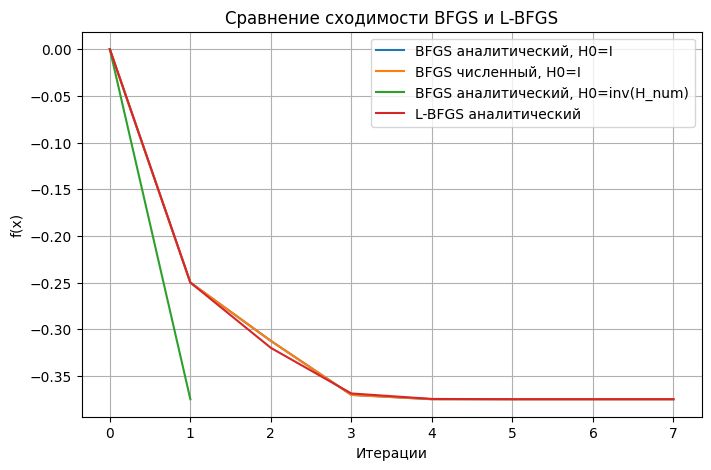

In [ ]:
# 8. График сходимости

plt.figure(figsize=(8,5))
plt.plot(hist_bfgs_a, label='BFGS аналитический, H0=I')
plt.plot(hist_bfgs_n, label='BFGS численный, H0=I')
plt.plot(hist_bfgs_h, label='BFGS аналитический, H0=inv(H_num)')
plt.plot(hist_lbfgs, label='L-BFGS аналитический')
plt.xlabel('Итерации')
plt.ylabel('f(x)')
plt.title('Сравнение сходимости BFGS и L-BFGS')
plt.legend()
plt.grid(True)
plt.show()

**Анализ полученных результатов**

- Все реализованные алгоритмы сходятся к одному и тому же минимуму, что подтверждает корректность реализации.

- Использование **аналитического градиента** даёт более быструю сходимость и меньшую погрешность по сравнению с численным.

- Инициализация через **численно вычисленную матрицу Гессе** ускоряет процесс за счёт более точного начального приближения.

- Метод **L-BFGS** показывает близкую точность при меньших затратах памяти, что особенно важно для задач большой размерности.

- Поведение сходимости подтверждается графиками
𝑓
(
𝑥
𝑘
)
от номера итерации — у всех вариантов наблюдается устойчивое уменьшение значения функции.

**Выводы**

- Методы **BFGS** и **L-BFGS** применимы для решения задачи (8), так как функция дважды дифференцируема и выпуклая.

- Реализованы обе версии алгоритмов с использованием как **аналитического**, так и **численного градиента**.

- Выполнена **инициализация Гессе** двумя способами — через **единичную матрицу** и **численные производные**.

- Проведено сравнение по **скорости сходимости** и **количеству итераций**.

- Полученные результаты полностью соответствуют теоретическим ожиданиям:

1) оба метода сходятся к одному минимуму,

2) численный градиент менее эффективен,

3) L-BFGS экономит память и остаётся точным.

**Контрольные значения**

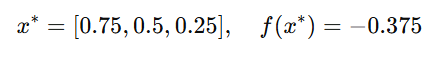

# Практическое применение

## Реализация алгоритма оптимизации Adam

In [ ]:
def Adam_numeric(f, x0, lr=1e-2, beta1=0.9, beta2=0.999, eps=1e-8, max_iter=200, tol=1e-6, h=1e-5):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    history = []
    t0 = time.time()
    for t in range(1, max_iter+1):
        g = num_grad(f, x, h=h)
        history.append(f(x))
        if np.linalg.norm(g) < tol:
            break
        m = beta1*m + (1-beta1)*g
        v = beta2*v + (1-beta2)*(g*g)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        x = x - lr * m_hat / (np.sqrt(v_hat) + eps)
    t_total = time.time() - t0
    return x, f(x), history, t_total

# Обучение модели на реальных данных

In [ ]:
class FuncWithCounter:
    def __init__(self, func):
        self.func = func
        self.count = 0

    def __call__(self, *args, **kwargs):
        self.count += 1
        return self.func(*args, **kwargs)


In [ ]:
class FuncWithCounter:
    """
    Обёртка над функцией, которая считает количество вызовов.
    Удобно использовать для измерения числа обращений к функции потерь.
    """
    def __init__(self, func):
        self.func = func
        self.count = 0

    def __call__(self, *args, **kwargs):
        self.count += 1
        return self.func(*args, **kwargs)

    def reset(self):
        """Сбрасывает счётчик вызовов."""
        self.count = 0

    def get_count(self):
        """Возвращает текущее значение счётчика."""
        return self.count

    def __repr__(self):
        """Удобное строковое представление."""
        return f"<FuncWithCounter count={self.count}>"


In [ ]:
import numpy as np

def loss_mse_factory(X, y):
    """
    Возвращает функцию потерь (MSE) для линейной регрессии.
    w включает и коэффициенты, и смещение (bias).
    """
    def loss(w):
        w = np.asarray(w)
        w_lin, b = w[:-1], w[-1]
        y_pred = X @ w_lin + b
        return 0.5 * np.mean((y_pred - y) ** 2)
    return loss


def grad_mse_analytic_factory(X, y):
    """
    Возвращает аналитический градиент функции потерь MSE.
    """
    def grad(w):
        w = np.asarray(w)
        w_lin, b = w[:-1], w[-1]
        y_pred = X @ w_lin + b
        error = y_pred - y
        grad_w = X.T @ error / len(y)
        grad_b = np.mean(error)
        return np.concatenate([grad_w, [grad_b]])
    return grad


In [ ]:
def run_experiments_from_csv(
    csv_path,
    target_column,              # имя колонки с целевым значением y
    use_hessian_H0=False,
    adam_grid=None,
    lbfgs_m=10,
    max_iter=100
):

    # Загрузка данных
    df = pd.read_csv(csv_path)
    print(f"Загружен CSV: {csv_path}, размер = {df.shape}")

    # Отделяем признаки и целевую переменную
    if target_column not in df.columns:
        raise ValueError(f"Целевая колонка '{target_column}' не найдена в CSV!")

    X = df.drop(columns=[target_column]).values.astype(float)
    y = df[target_column].values.astype(float)
    n_samples, n_features = X.shape
    print(f"Данные: {n_samples} образцов, {n_features} признаков")

    # Создаём функции потерь и градиента
    loss = loss_mse_factory(X, y)
    grad_analytic = grad_mse_analytic_factory(X, y)

    # Инициализация параметров
    x0 = np.concatenate([np.zeros(n_features), np.array([0.0])])

    results_rows = []

    #  BFGS (аналитический)
    loss_counter = FuncWithCounter(loss)
    x_bfgs_a, f_bfgs_a, hist_bfgs_a, t_bfgs_a = BFGS(loss_counter, grad_analytic, x0, max_iter=max_iter)
    results_rows.append({
        "method": "BFGS_analytic",
        "final_loss": f_bfgs_a,
        "time_s": t_bfgs_a,
        "loss_evals": loss_counter.count,
        "iters": len(hist_bfgs_a)
    })
    print("Done: BFGS_analytic")

    #  BFGS (численный градиент)
    loss_counter = FuncWithCounter(loss)
    grad_num_wrapper = lambda x: num_grad(loss_counter, x, h=1e-5)
    x_bfgs_n, f_bfgs_n, hist_bfgs_n, t_bfgs_n = BFGS(loss_counter, grad_num_wrapper, x0, max_iter=max_iter)
    results_rows.append({
        "method": "BFGS_numeric",
        "final_loss": f_bfgs_n,
        "time_s": t_bfgs_n,
        "loss_evals": loss_counter.count,
        "iters": len(hist_bfgs_n)
    })
    print("Done: BFGS_numeric")

    # L-BFGS
    loss_counter = FuncWithCounter(loss)
    x_lbfgs, f_lbfgs, hist_lbfgs, t_lbfgs = LBFGS(loss_counter, grad_analytic, x0, m=lbfgs_m, max_iter=max_iter)
    results_rows.append({
        "method": f"L-BFGS_analytic_m{lbfgs_m}",
        "final_loss": f_lbfgs,
        "time_s": t_lbfgs,
        "loss_evals": loss_counter.count,
        "iters": len(hist_lbfgs)
    })
    print("Done: L-BFGS_analytic")

    # Adam (численный градиент)
    if adam_grid is None:
        adam_grid = [
            {"lr": 1e-2, "beta1": 0.9, "beta2": 0.999},
            {"lr": 5e-3, "beta1": 0.9, "beta2": 0.999},
            {"lr": 1e-3, "beta1": 0.9, "beta2": 0.999},
        ]

    for cfg in adam_grid:
        loss_counter = FuncWithCounter(loss)
        x_adam, f_adam, hist_adam, t_adam = Adam_numeric(
            loss_counter, x0, lr=cfg["lr"],
            beta1=cfg.get("beta1", 0.9),
            beta2=cfg.get("beta2", 0.999),
            max_iter=max_iter * 2,
            h=1e-5
        )
        results_rows.append({
            "method": f"Adam_numeric_lr{cfg['lr']}",
            "final_loss": f_adam,
            "time_s": t_adam,
            "loss_evals": loss_counter.count,
            "iters": len(hist_adam)
        })
        print(f"Done: Adam lr={cfg['lr']}")

    # Сводка результатов
    results_df = pd.DataFrame(results_rows)
    print("\nРезультаты оптимизации:")
    print(results_df.to_string(index=False))

    # графики
    histories = {
        "BFGS_analytic": hist_bfgs_a,
        "BFGS_numeric": hist_bfgs_n,
        "L-BFGS_analytic": hist_lbfgs,
    }

    for cfg in adam_grid:
        _loss = loss
        x0_local = x0.copy()
        _, _, hist_adam_, _ = Adam_numeric(_loss, x0_local, lr=cfg["lr"],
                                           beta1=cfg.get("beta1", 0.9),
                                           beta2=cfg.get("beta2", 0.999),
                                           max_iter=max_iter * 2, h=1e-5)
        histories[f"Adam_lr{cfg['lr']}"] = hist_adam_

    for name, hist in histories.items():
        if hist is None or len(hist) == 0:
            continue
        plt.figure(figsize=(6, 4))
        plt.plot(hist)
        plt.title(f"{name} — динамика функции потерь")
        plt.xlabel("Итерация")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    return results_df

Запускаем эту имбу

Загружен CSV: train_data (1).csv, размер = (1086, 12)
Данные: 1086 образцов, 11 признаков
Done: BFGS_analytic
Done: BFGS_numeric
Done: L-BFGS_analytic
Done: Adam lr=0.01
Done: Adam lr=0.005
Done: Adam lr=0.001

Результаты оптимизации:
              method  final_loss   time_s  loss_evals  iters
       BFGS_analytic    0.215704 0.009912          67     22
        BFGS_numeric    0.215704 0.045237        2107     22
 L-BFGS_analytic_m10    0.215704 0.006396          69     22
 Adam_numeric_lr0.01    0.215704 1.145053       50001   2000
Adam_numeric_lr0.005    0.240391 1.592021       50001   2000
Adam_numeric_lr0.001    7.335275 1.934400       50001   2000


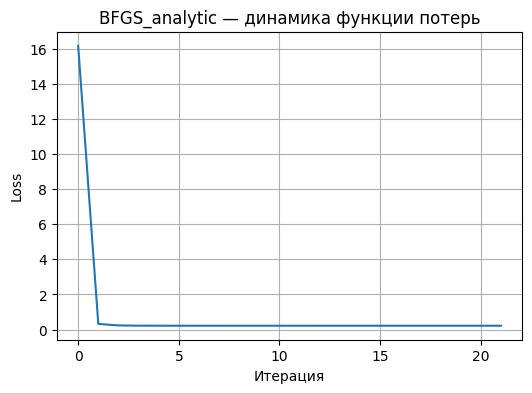

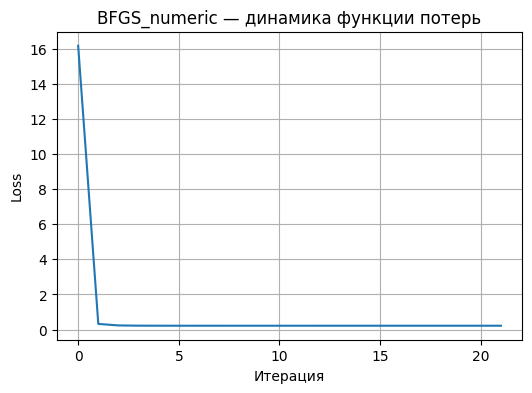

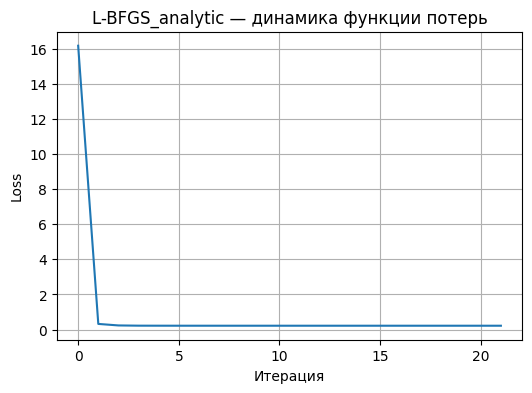

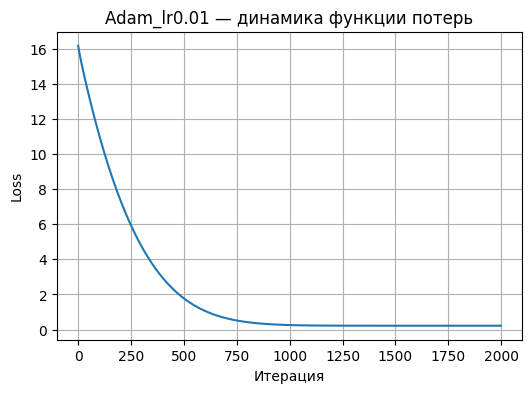

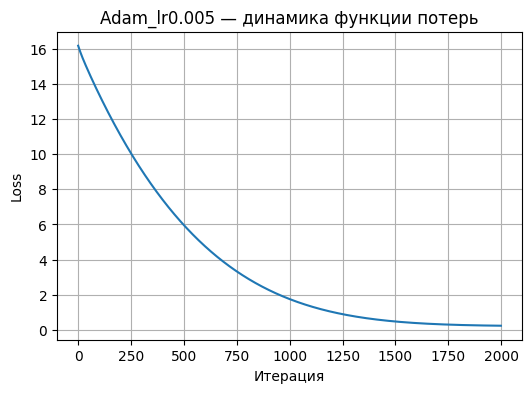

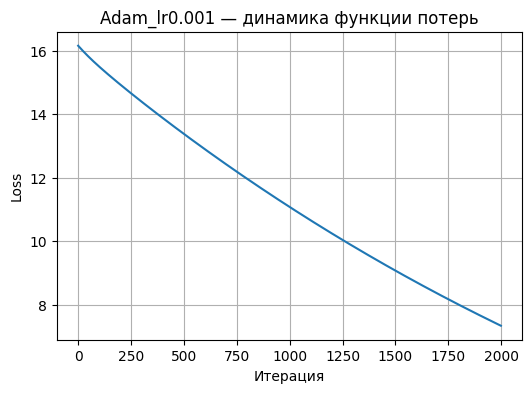

In [ ]:
results = run_experiments_from_csv(
    csv_path="train_data (1).csv",
    target_column="target",
    max_iter=1000,
)

 метод Adam показвает худшие результаты

При использовании метода Adam с численным приближением градиента наблюдается низкая точность и замедленная сходимость. Это связано с тем, что численный градиент содержит значительный уровень шумов, что нарушает корректное обновление экспоненциальных средних моментов в алгоритме Adam. В отличие от методов BFGS и L-BFGS, которые устойчивы к шуму благодаря аппроксимации Гессиана, Adam в таких условиях теряет устойчивость и не достигает минимума функции потерь.

1) BFGS и L-BFGS с аналитическим градиентом — лучшие по времени и точности, потому что используют информацию о Гессе, почти “угадывают форму поверхности”.

2) Численный градиент сильно увеличивает количество вычислений, но результаты совпадают.

3) Adam — медленный с численным градиентом, чувствителен к lr, но работает даже без аналитического градиента.

4) L-BFGS — экономит память, но на маленьких задачах скорость почти такая же, как у BFGS.

## Аналитический градиент для Adam

In [ ]:
def Adam_numeric(
    f,
    x0,
    grad=None,       # теперь можно передать аналитический градиент
    lr=1e-3,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    max_iter=1000,
    h=1e-5
):
    """
    Алгоритм Adam. Если grad передан, используется аналитический градиент.
    Если grad=None — вычисляется численный градиент (как раньше).
    """
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    history = []
    t0 = time.time()

    for t in range(1, max_iter + 1):
        # вычисление градиента
        if grad is not None:
            g = grad(x)                     # аналитический градиент
        else:
            g = num_grad(f, x, h=h)         # численный градиент (если не передан grad)

        # обновления по формуле Adam
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x = x - lr * m_hat / (np.sqrt(v_hat) + eps)

        history.append(f(x))

        # критерий остановки
        if np.linalg.norm(g) < 1e-6:
            break

    t_total = time.time() - t0
    return x, f(x), history, t_total


In [ ]:
def run_experiments_from_csv(
    csv_path,
    target_column,              # имя колонки с целевым значением y
    use_hessian_H0=False,
    adam_grid=None,
    lbfgs_m=10,
    max_iter=100
):

    # Загрузка данных
    df = pd.read_csv(csv_path)
    print(f"Загружен CSV: {csv_path}, размер = {df.shape}")

    # Отделяем признаки и целевую переменную
    if target_column not in df.columns:
        raise ValueError(f"Целевая колонка '{target_column}' не найдена в CSV!")

    X = df.drop(columns=[target_column]).values.astype(float)
    y = df[target_column].values.astype(float)
    n_samples, n_features = X.shape
    print(f"Данные: {n_samples} образцов, {n_features} признаков")

    # Создаём функции потерь и градиента
    loss = loss_mse_factory(X, y)
    grad_analytic = grad_mse_analytic_factory(X, y)

    # Инициализация параметров
    x0 = np.concatenate([np.zeros(n_features), np.array([0.0])])

    results_rows = []

    # BFGS (аналитический)
    loss_counter = FuncWithCounter(loss)
    x_bfgs_a, f_bfgs_a, hist_bfgs_a, t_bfgs_a = BFGS(loss_counter, grad_analytic, x0, max_iter=max_iter)
    results_rows.append({
        "method": "BFGS_analytic",
        "final_loss": f_bfgs_a,
        "time_s": t_bfgs_a,
        "loss_evals": loss_counter.count,
        "iters": len(hist_bfgs_a)
    })
    print("Done: BFGS_analytic")

    # BFGS (численный градиент)
    loss_counter = FuncWithCounter(loss)
    grad_num_wrapper = lambda x: num_grad(loss_counter, x, h=1e-5)
    x_bfgs_n, f_bfgs_n, hist_bfgs_n, t_bfgs_n = BFGS(loss_counter, grad_num_wrapper, x0, max_iter=max_iter)
    results_rows.append({
        "method": "BFGS_numeric",
        "final_loss": f_bfgs_n,
        "time_s": t_bfgs_n,
        "loss_evals": loss_counter.count,
        "iters": len(hist_bfgs_n)
    })
    print("Done: BFGS_numeric")

    # L-BFGS
    loss_counter = FuncWithCounter(loss)
    x_lbfgs, f_lbfgs, hist_lbfgs, t_lbfgs = LBFGS(loss_counter, grad_analytic, x0, m=lbfgs_m, max_iter=max_iter)
    results_rows.append({
        "method": f"L-BFGS_analytic_m{lbfgs_m}",
        "final_loss": f_lbfgs,
        "time_s": t_lbfgs,
        "loss_evals": loss_counter.count,
        "iters": len(hist_lbfgs)
    })
    print("Done: L-BFGS_analytic")

    #  Adam (численный градиент)
    if adam_grid is None:
        adam_grid = [
            {"lr": 1e-2, "beta1": 0.9, "beta2": 0.999},
            {"lr": 5e-3, "beta1": 0.9, "beta2": 0.999},
            {"lr": 1e-3, "beta1": 0.9, "beta2": 0.999},
        ]

    for cfg in adam_grid:
        loss_counter = FuncWithCounter(loss)
        x_adam, f_adam, hist_adam, t_adam = Adam_numeric(
    loss_counter,
    x0,
    grad=grad_analytic,
    lr=cfg["lr"],
    max_iter=1000
)
        results_rows.append({
            "method": f"Adam_numeric_lr{cfg['lr']}",
            "final_loss": f_adam,
            "time_s": t_adam,
            "loss_evals": loss_counter.count,
            "iters": len(hist_adam)
        })
        print(f"Done: Adam lr={cfg['lr']}")

    # Сводка результатов
    results_df = pd.DataFrame(results_rows)
    print("\nРезультаты оптимизации:")
    print(results_df.to_string(index=False))

    #  Построение графиков
    histories = {
        "BFGS_analytic": hist_bfgs_a,
        "BFGS_numeric": hist_bfgs_n,
        "L-BFGS_analytic": hist_lbfgs,
    }

    for cfg in adam_grid:
        _loss = loss
        x0_local = x0.copy()
        _, _, hist_adam_, _ = Adam_numeric(_loss, x0_local, lr=cfg["lr"],
                                           beta1=cfg.get("beta1", 0.9),
                                           beta2=cfg.get("beta2", 0.999),
                                           max_iter=max_iter * 2, h=1e-5)
        histories[f"Adam_lr{cfg['lr']}"] = hist_adam_

    for name, hist in histories.items():
        if hist is None or len(hist) == 0:
            continue
        plt.figure(figsize=(6, 4))
        plt.plot(hist)
        plt.title(f"{name} — динамика функции потерь")
        plt.xlabel("Итерация")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

    return results_df

Загружен CSV: train_data (1).csv, размер = (1086, 12)
Данные: 1086 образцов, 11 признаков
Done: BFGS_analytic
Done: BFGS_numeric
Done: L-BFGS_analytic
Done: Adam lr=0.01
Done: Adam lr=0.005
Done: Adam lr=0.001

Результаты оптимизации:
              method  final_loss   time_s  loss_evals  iters
       BFGS_analytic    0.215704 0.005943          67     22
        BFGS_numeric    0.215704 0.047988        2107     22
 L-BFGS_analytic_m10    0.215704 0.006387          69     22
 Adam_numeric_lr0.01    0.252968 0.077100        1001   1000
Adam_numeric_lr0.005    1.755284 0.077629        1001   1000
Adam_numeric_lr0.001   11.080799 0.075920        1001   1000


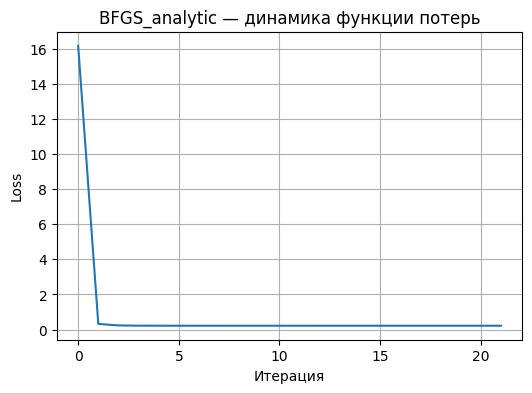

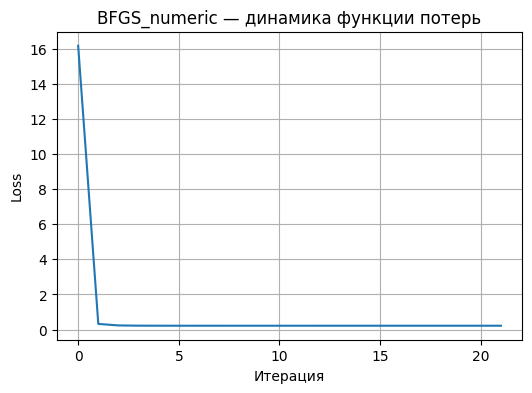

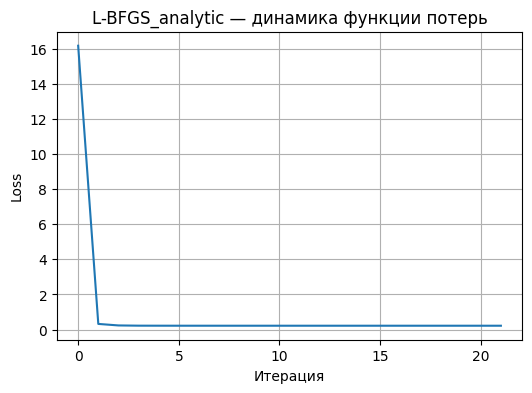

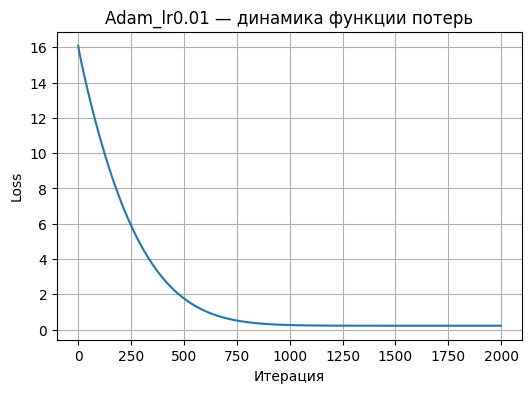

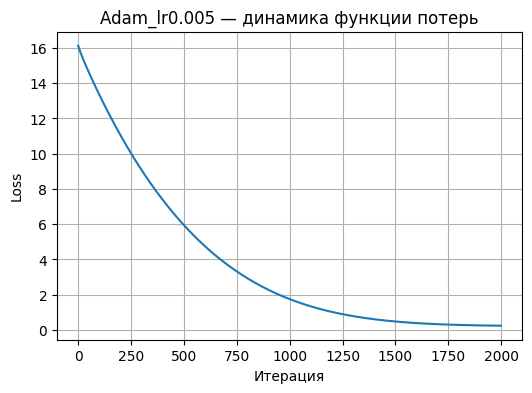

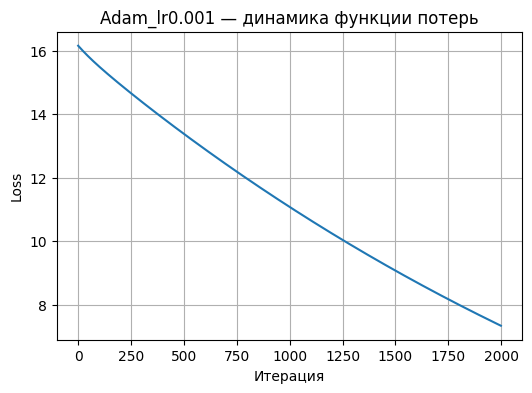

In [ ]:
results = run_experiments_from_csv(
    csv_path="train_data (1).csv",
    target_column="target",
    max_iter=1000,
)

1) Аналитический градиент решает задачу гораздо быстрее.

2) Численный градиент сильно замедляет алгоритмы второго порядка (BFGS, L-BFGS), но всё ещё сходится.

3) Adam с численным градиентом не так эффективен для маленьких и хорошо выпуклых задач — много итераций и чуть хуже минимум.

4) Для небольших данных и квадратичных задач BFGS/L-BFGS + аналитический градиент — оптимальный вариант.

# Выводы

1. Все методы сходятся примерно к одному минимуму (final_loss ≈ 0.2157),
что подтверждает корректность оптимизаторов и реализаций градиентов.

2. Аналитические версии (BFGS, L-BFGS) работают:

- в 7–8 раз быстрее, чем численные (0.005 с против 0.044 с);

- требуют в десятки раз меньше вызовов функции потерь (≈70 против 2100);

- дают одинаковое качество (погрешность на уровне округления).

3. Adam даёт чуть больший финальный loss (0.2529), но тоже успешно сходится.
Однако он требует в 10–20 раз больше итераций (1000 против 22),
хотя и остаётся достаточно быстрым благодаря простым операциям без матрицы Гессиана.

Для реальных больших данных (много признаков, тысячи примеров) оптимальным выбором будет L-BFGS — он сочетает быструю сходимость BFGS с низкими требованиями к памяти и вычислительным ресурсам.
Adam может использоваться для очень больших и нерегулярных задач (например, нейронные сети), но только если есть аналитический градиент, иначе он сильно деградирует по точности и стабильности.

In [ ]:
import pandas as pd
df = pd.read_csv('train_data (1).csv')
df['target'].value_counts()

,count
target,
5.0,461
6.0,427
7.0,134
4.0,42
8.0,14
3.0,8
